# Librerias requeridas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder, StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, f1_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict
import joblib
import os
import time
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
)


# Importar datos

In [3]:
#Data sets despues de eliminar variables de alta correlacion
Data_regres_filtrado = pd.read_csv("../data/wine_data_train_regression_filtrado.csv")
Data_regres_filtrado = pd.DataFrame(Data_regres_filtrado)
print(f"\n🔹 Columnas en regresion:\n{Data_regres_filtrado.columns.tolist()}")


🔹 Columnas en regresion:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


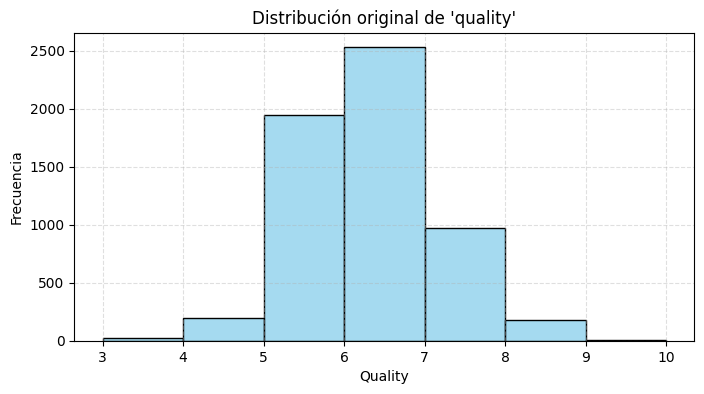

In [4]:
# ==============================================
# 📊 Distribución de la variable objetivo 'quality'
# ==============================================

# Histograma original (valores numéricos)
plt.figure(figsize=(8,4))
sns.histplot(Data_regres_filtrado['quality'], bins=range(3, 11), kde=False, color='skyblue', edgecolor='black')
plt.title("Distribución original de 'quality'")
plt.xlabel("Quality")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()



In [5]:
# =====================================================
# 🧹 PREPROCESAMIENTO Y DIVISIÓN DE DATOS (CELDA BASE)
# =====================================================
#@markdown En esta celda se prepara el dataset de regresión:
#@markdown - Se eliminan columnas no numéricas  
#@markdown - Se limpian valores infinitos o faltantes  
#@markdown - Se divide el conjunto en entrenamiento y prueba (80/20)


# --- 1️⃣ Detección de columnas no numéricas
no_numericas = Data_regres_filtrado.select_dtypes(exclude=np.number).columns.tolist()
print(f"🔍 Columnas no numéricas detectadas: {no_numericas}")

# --- 2️⃣ Selección de solo variables numéricas y separación de target
X = Data_regres_filtrado.select_dtypes(include=np.number).drop(columns=["quality"])
y = Data_regres_filtrado["quality"]

# --- 3️⃣ Limpieza de valores infinitos o faltantes
X = X.replace([np.inf, -np.inf], np.nan).dropna()

print(f"✅ Dataset final listo para modelado: {X.shape[0]} observaciones y {X.shape[1]} variables numéricas.\n")

# --- 4️⃣ División del dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y.loc[X.index], test_size=0.2, random_state=42
)

print(f"📂 Tamaño del set de entrenamiento: {X_train.shape[0]}")
print(f"📂 Tamaño del set de prueba: {X_test.shape[0]}\n")


🔍 Columnas no numéricas detectadas: []
✅ Dataset final listo para modelado: 5847 observaciones y 10 variables numéricas.

📂 Tamaño del set de entrenamiento: 4677
📂 Tamaño del set de prueba: 1170



In [20]:

# ================================================================================
# PASO 5: MODELO BASELINE (CON PARÁMETROS CALIBRADOS)
# ================================================================================
#@markdown En este paso se entrena un modelo **Random Forest Regressor** con los
#@markdown parámetros ajustados actualmente (según calibración previa).  
#@markdown Se evalúa el rendimiento en train y test mediante R², RMSE, MAE y MAPE.

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
)
import numpy as np

print("="*80)
print("🎯 MODELO BASELINE - Random Forest Regressor (Calibrado)")
print("="*80)

# Crear y entrenar modelo baseline con los parámetros actuales
rf_calibrado = RandomForestRegressor(
    n_estimators=602,        # Número de árboles
    max_depth=20,          # Sin límite de profundidad
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=False,
)

print("\n⏳ Entrenando modelo calibrado...")
rf_calibrado.fit(X_train, y_train)
print("✅ Entrenamiento completado.")

# Predicciones
y_train_pred = rf_calibrado.predict(X_train)
y_test_pred = rf_calibrado.predict(X_test)

# ================================================================================
# 📊 MÉTRICAS DE DESEMPEÑO
# ================================================================================
print(f"\n{'Métrica':<25} {'Train':<15} {'Test':<15}")
print("-" * 55)

# R² Score
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f"{'R² Score':<25} {r2_train:<15.4f} {r2_test:<15.4f}")

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"{'RMSE':<25} {rmse_train:<15.4f} {rmse_test:<15.4f}")

# MAE
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"{'MAE':<25} {mae_train:<15.4f} {mae_test:<15.4f}")

# MAPE
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
print(f"{'MAPE (%)':<25} {mape_train*100:<15.2f} {mape_test*100:<15.2f}")

# ================================================================================
# 💬 INTERPRETACIÓN
# ================================================================================
print("\n💡 Interpretación:")
print(f"   • R² Test:  {r2_test:.4f}  → Explica el {r2_test*100:.2f}% de la varianza en la calidad del vino.")
print(f"   • RMSE Test: {rmse_test:.4f}  → Error cuadrático medio de ±{rmse_test:.2f} puntos de calidad.")
print(f"   • MAE Test:  {mae_test:.4f}  → Error absoluto medio de ±{mae_test:.2f} puntos de calidad.\n")


🎯 MODELO BASELINE - Random Forest Regressor (Calibrado)

⏳ Entrenando modelo calibrado...
✅ Entrenamiento completado.
✅ Entrenamiento completado.

Métrica                   Train           Test           
-------------------------------------------------------
R² Score                  0.9981          0.5322         
RMSE                      0.0379          0.5917         
MAE                       0.0223          0.3860         
MAPE (%)                  0.40            7.07           

💡 Interpretación:
   • R² Test:  0.5322  → Explica el 53.22% de la varianza en la calidad del vino.
   • RMSE Test: 0.5917  → Error cuadrático medio de ±0.59 puntos de calidad.
   • MAE Test:  0.3860  → Error absoluto medio de ±0.39 puntos de calidad.


Métrica                   Train           Test           
-------------------------------------------------------
R² Score                  0.9981          0.5322         
RMSE                      0.0379          0.5917         
MAE                   

| Gráfico                         | Qué muestra                        | Interpretación                                                                                               |
| ------------------------------- | ---------------------------------- | ------------------------------------------------------------------------------------------------------------ |
| **Evolución del R² (CV)**       | Cada punto = configuración probada | Variación natural; varias combinaciones se acercan al óptimo (≈0.47), indicando **robustez**.                |
| **Overfitting (Train vs Test)** | R² CV-train vs CV-test             | El mejor modelo (estrella roja) está **cerca de la diagonal**, → buen balance entre ajuste y generalización. |
| **Distribución de Scores**      | Histograma de R² CV                | Concentrado entre 0.35–0.47 → la mayoría de configuraciones razonables; espacio bien definido.               |
| **Impacto de n_estimators**     | Relación árboles ↔ R²              | Tendencia plana → más de ~300 árboles **no mejoran sustancialmente**.                                        |
| **Impacto de max_depth**        | Boxplots por profundidad           | `40` y `None` dan los mejores resultados → árboles profundos son útiles.                                     |
| **Impacto de max_features**     | Diferentes estrategias             | `'sqrt'` domina; `'log2'` tiene menor rendimiento → confirma que la calibración original era adecuada.       |
| **Impacto de bootstrap**        | True vs False                      | `False` obtiene mejores medianas → usar todo el dataset mejora consistencia.                                 |


🔍 OPTIMIZACIÓN DE HIPERPARÁMETROS CON RANDOMIZEDSEARCHCV

────────────────────────────────────────────────────────────────────────────────
📋 ESPACIO DE BÚSQUEDA DE HIPERPARÁMETROS
────────────────────────────────────────────────────────────────────────────────

- n_estimators        : randint(200, 600)   → incluye 300 (calibrado)
- max_depth           : [10, 20, 30, 40, None]
- min_samples_split   : randint(2, 20)
- min_samples_leaf    : randint(1, 10)
- max_features        : ['sqrt', 'log2', None]  (incluye 'sqrt')
- bootstrap           : [True, False]


⏳ Iniciando búsqueda aleatoria (50 iteraciones, CV=5)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✅ OPTIMIZACIÓN COMPLETADA en 1.81 min (108.7 s)

🏆 MEJORES HIPERPARÁMETROS ENCONTRADOS
• bootstrap         : False
• max_depth         : 40
• max_features      : sqrt
• min_samples_leaf  : 1
• min_samples_split : 9
• n_estimators      : 327

📊 Mejor R² (CV): 0.4733 | Ranking: 40 / 50

📊 MÉTRICAS DEL MEJOR MODELO (ENTR

C:\Users\juanc\AppData\Local\Temp\ipykernel_29612\1244079644.py:185: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax5.boxplot(data_md, labels=labels_md, patch_artist=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_29612\1244079644.py:195: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax6.boxplot(data_mf, labels=unique_mf, patch_artist=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_29612\1244079644.py:205: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp3 = ax7.boxplot(data_bs, labels=['True','False'], patch_artist=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_29612\1244079644.py:211: UserWarning: 

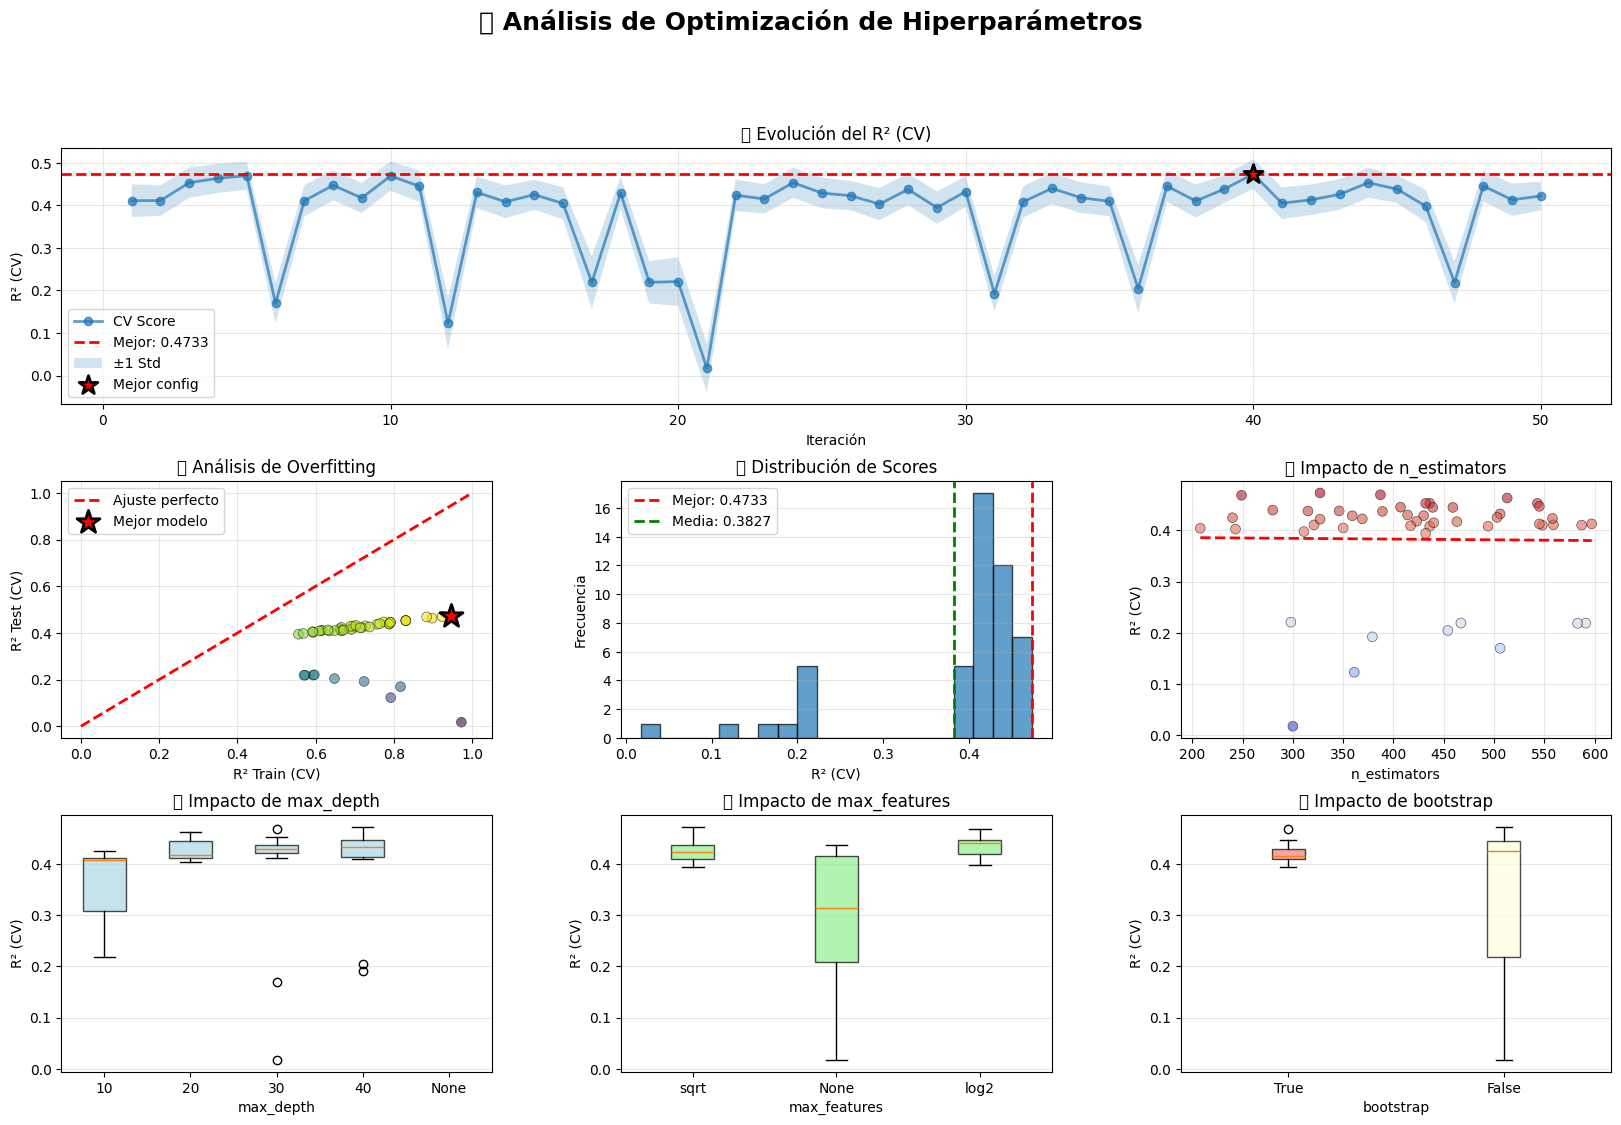


🏅 TOP 10 MEJORES CONFIGURACIONES (por mean_test_score)
 mean_test_score  std_test_score  param_n_estimators param_max_depth  param_min_samples_split  param_min_samples_leaf param_max_features  param_bootstrap  rank_test_score
        0.473275        0.034791                 327              40                        9                       1               sqrt            False                1
        0.469659        0.032976                 387            None                       11                       1               sqrt            False                2
        0.468729        0.034704                 249              30                        5                       1               log2             True                3
        0.463291        0.034182                 513              20                       13                       1               sqrt            False                4
        0.453014        0.035257                 436            None                     

In [7]:
# ================================================================================
# PASO 6: OPTIMIZACIÓN CON RANDOMIZEDSEARCHCV
# ================================================================================
#@markdown En este paso se optimizan los hiperparámetros del Random Forest mediante
#@markdown **RandomizedSearchCV (5-fold CV)**. Se reportan mejores parámetros,
#@markdown evolución de scores y análisis gráfico del espacio explorado.



print("="*80)
print("🔍 OPTIMIZACIÓN DE HIPERPARÁMETROS CON RANDOMIZEDSEARCHCV")
print("="*80)

# ------------------------------------------------------------------------------
# Baseline de referencia (si no traemos r2_test desde el PASO 5, lo calculamos aquí)
# ------------------------------------------------------------------------------
try:
    _ = r2_test  # solo para chequear existencia
    baseline_disponible = True
except NameError:
    baseline_disponible = False

if not baseline_disponible:
    rf_calibrado = RandomForestRegressor(
        n_estimators=300, max_depth=None,
        min_samples_split=2, min_samples_leaf=1,
        max_features='sqrt', random_state=42, n_jobs=-1
    )
    print("\n⏳ Entrenando baseline calibrado (referencia previa ausente)...")
    rf_calibrado.fit(X_train, y_train)
    y_test_pred_base = rf_calibrado.predict(X_test)
    y_train_pred_base = rf_calibrado.predict(X_train)

    r2_train = r2_score(y_train, y_train_pred_base)
    r2_test  = r2_score(y_test,  y_test_pred_base)
    rmse_test = mean_squared_error(y_test, y_test_pred_base, squared=False)
    mae_test  = mean_absolute_error(y_test, y_test_pred_base)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred_base)

    print("✅ Baseline calibrado entrenado (para referencia en el resumen)")
    print(f"   R² Train: {r2_train:.4f} | R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f} | MAE Test: {mae_test:.4f}")

# ------------------------------------------------------------------------------
# Espacio de búsqueda (incluye la calibración actual en el rango)
# ------------------------------------------------------------------------------
param_distributions = {
    'n_estimators': randint(200, 600),          # incluye 300
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],     # incluye 'sqrt' (nuestra calibración)
    'bootstrap': [True, False]
}

print("\n" + "─"*80)
print("📋 ESPACIO DE BÚSQUEDA DE HIPERPARÁMETROS")
print("─"*80)
print(f"""
- n_estimators        : randint(200, 600)   → incluye 300 (calibrado)
- max_depth           : {param_distributions['max_depth']}
- min_samples_split   : randint(2, 20)
- min_samples_leaf    : randint(1, 10)
- max_features        : {param_distributions['max_features']}  (incluye 'sqrt')
- bootstrap           : {param_distributions['bootstrap']}
""")

# ------------------------------------------------------------------------------
# Configurar y ejecutar RandomizedSearchCV
# ------------------------------------------------------------------------------
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=50,                  # combinaciones a probar
    cv=5,                       # 5-fold CV
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

print("\n⏳ Iniciando búsqueda aleatoria (50 iteraciones, CV=5)...\n" + "="*80)
start_time = time.time()
random_search.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print("="*80)
print(f"✅ OPTIMIZACIÓN COMPLETADA en {elapsed_time/60:.2f} min ({elapsed_time:.1f} s)")

# ------------------------------------------------------------------------------
# Resultados y mejor modelo
# ------------------------------------------------------------------------------
best_params = random_search.best_params_
best_score  = random_search.best_score_
best_rf     = random_search.best_estimator_

print("\n" + "="*80)
print("🏆 MEJORES HIPERPARÁMETROS ENCONTRADOS")
print("="*80)
for k, v in best_params.items():
    print(f"• {k:<18}: {v}")
print(f"\n📊 Mejor R² (CV): {best_score:.4f} | Ranking: {random_search.best_index_ + 1} / 50")

# ------------------------------------------------------------------------------
# Evaluación del mejor modelo en TEST
# ------------------------------------------------------------------------------
y_test_pred_opt = best_rf.predict(X_test)
y_train_pred_opt = best_rf.predict(X_train)

r2_train_opt = r2_score(y_train, y_train_pred_opt)
r2_test_opt  = r2_score(y_test,  y_test_pred_opt)
rmse_test_opt = np.sqrt(mean_squared_error(y_test, y_test_pred_opt))

mae_test_opt  = mean_absolute_error(y_test, y_test_pred_opt)
mape_test_opt = mean_absolute_percentage_error(y_test, y_test_pred_opt)

print("\n" + "="*80)
print("📊 MÉTRICAS DEL MEJOR MODELO (ENTRENADO EN TRAIN Y EVALUADO EN TEST)")
print("="*80)
print(f"{'Métrica':<18} {'Train':<12} {'Test':<12}")
print("-"*45)
print(f"{'R²':<18} {r2_train_opt:<12.4f} {r2_test_opt:<12.4f}")
print(f"{'RMSE':<18} {'-':<12} {rmse_test_opt:<12.4f}")
print(f"{'MAE':<18} {'-':<12} {mae_test_opt:<12.4f}")
print(f"{'MAPE (%)':<18} {'-':<12} {mape_test_opt*100:<12.2f}")

# ------------------------------------------------------------------------------
# Visualizaciones del proceso
# ------------------------------------------------------------------------------
cv_results = pd.DataFrame(random_search.cv_results_)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
fig.suptitle('🔍 Análisis de Optimización de Hiperparámetros', fontsize=18, fontweight='bold', y=0.995)

# 1) Evolución de score
ax1 = fig.add_subplot(gs[0, :])
iters = np.arange(1, len(cv_results) + 1)
ax1.plot(iters, cv_results['mean_test_score'], 'o-', linewidth=2, markersize=6, alpha=0.7, label='CV Score')
ax1.axhline(y=best_score, color='red', linestyle='--', linewidth=2, label=f'Mejor: {best_score:.4f}')
ax1.fill_between(iters,
                 cv_results['mean_test_score'] - cv_results['std_test_score'],
                 cv_results['mean_test_score'] + cv_results['std_test_score'],
                 alpha=0.2, label='±1 Std')
ax1.scatter(random_search.best_index_ + 1, best_score, color='red', s=200, marker='*',
            zorder=5, edgecolors='black', linewidths=2, label='Mejor config')
ax1.set_title('📊 Evolución del R² (CV)')
ax1.set_xlabel('Iteración'); ax1.set_ylabel('R² (CV)'); ax1.legend(); ax1.grid(True, alpha=0.3)

# 2) Overfitting: Train vs Test (CV)
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(cv_results['mean_train_score'], cv_results['mean_test_score'],
            c=cv_results['mean_test_score'], cmap='viridis', s=50, alpha=0.6,
            edgecolors='black', linewidth=0.5)
ax2.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Ajuste perfecto')
ax2.scatter(cv_results.iloc[random_search.best_index_]['mean_train_score'],
            cv_results.iloc[random_search.best_index_]['mean_test_score'],
            color='red', s=300, marker='*', zorder=5,
            edgecolors='black', linewidths=2, label='Mejor modelo')
ax2.set_title('🎯 Análisis de Overfitting')
ax2.set_xlabel('R² Train (CV)'); ax2.set_ylabel('R² Test (CV)'); ax2.legend(); ax2.grid(True, alpha=0.3)

# 3) Distribución de scores
ax3 = fig.add_subplot(gs[1, 1])
ax3.hist(cv_results['mean_test_score'], bins=20, edgecolor='black', alpha=0.7)
ax3.axvline(best_score, color='red', linestyle='--', linewidth=2, label=f'Mejor: {best_score:.4f}')
ax3.axvline(cv_results['mean_test_score'].mean(), color='green', linestyle='--', linewidth=2,
            label=f"Media: {cv_results['mean_test_score'].mean():.4f}")
ax3.set_title('📊 Distribución de Scores'); ax3.set_xlabel('R² (CV)'); ax3.set_ylabel('Frecuencia')
ax3.legend(); ax3.grid(True, alpha=0.3, axis='y')

# 4) Impacto de n_estimators
ax4 = fig.add_subplot(gs[1, 2])
param_n = cv_results['param_n_estimators'].astype(int)
ax4.scatter(param_n, cv_results['mean_test_score'], c=cv_results['mean_test_score'],
            cmap='coolwarm', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
ax4.set_title('🌳 Impacto de n_estimators'); ax4.set_xlabel('n_estimators'); ax4.set_ylabel('R² (CV)')
coef = np.polyfit(param_n, cv_results['mean_test_score'], 1)
ax4.plot(sorted(param_n), np.poly1d(coef)(sorted(param_n)), "r--", linewidth=2); ax4.grid(True, alpha=0.3)

# 5) Impacto de max_depth
ax5 = fig.add_subplot(gs[2, 0])
param_md = cv_results['param_max_depth'].apply(lambda x: 50 if x is None else int(x))
labels_md = ['10','20','30','40','None']
data_md = [cv_results[cv_results['param_max_depth']==d]['mean_test_score'].values for d in [10,20,30,40,None]]
bp = ax5.boxplot(data_md, labels=labels_md, patch_artist=True)
for b in bp['boxes']: b.set_facecolor('lightblue'); b.set_alpha(0.7)
ax5.set_title('📏 Impacto de max_depth'); ax5.set_xlabel('max_depth'); ax5.set_ylabel('R² (CV)')
ax5.grid(True, alpha=0.3, axis='y')

# 6) Impacto de max_features
ax6 = fig.add_subplot(gs[2, 1])
param_mf = cv_results['param_max_features'].astype(str)
unique_mf = list(param_mf.unique())
data_mf = [cv_results[param_mf == mf]['mean_test_score'].values for mf in unique_mf]
bp2 = ax6.boxplot(data_mf, labels=unique_mf, patch_artist=True)
for b in bp2['boxes']: b.set_facecolor('lightgreen'); b.set_alpha(0.7)
ax6.set_title('🎲 Impacto de max_features'); ax6.set_xlabel('max_features'); ax6.set_ylabel('R² (CV)')
ax6.grid(True, alpha=0.3, axis='y')

# 7) Impacto de bootstrap
ax7 = fig.add_subplot(gs[2, 2])
param_bs = cv_results['param_bootstrap'].astype(bool)
data_bs = [cv_results[param_bs == True]['mean_test_score'].values,
           cv_results[param_bs == False]['mean_test_score'].values]
bp3 = ax7.boxplot(data_bs, labels=['True','False'], patch_artist=True)
bp3['boxes'][0].set_facecolor('lightcoral'); bp3['boxes'][1].set_facecolor('lightyellow')
for b in bp3['boxes']: b.set_alpha(0.7)
ax7.set_title('🎒 Impacto de bootstrap'); ax7.set_xlabel('bootstrap'); ax7.set_ylabel('R² (CV)')
ax7.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# Top-10 configuraciones
# ------------------------------------------------------------------------------
print("\n" + "="*80)
print("🏅 TOP 10 MEJORES CONFIGURACIONES (por mean_test_score)")
print("="*80)
top_10 = cv_results.nlargest(10, 'mean_test_score')[
    ['mean_test_score','std_test_score',
     'param_n_estimators','param_max_depth','param_min_samples_split',
     'param_min_samples_leaf','param_max_features','param_bootstrap','rank_test_score']
]
print(top_10.to_string(index=False))

# ------------------------------------------------------------------------------
# Resumen ejecutivo
# ------------------------------------------------------------------------------
print("\n" + "="*80)
print("📋 RESUMEN EJECUTIVO DE LA OPTIMIZACIÓN")
print("="*80)
mejora_pct = ((best_score - r2_test) / r2_test * 100) if r2_test != 0 else np.nan
print(f"""
⏱️  Tiempo total: {elapsed_time/60:.2f} min  |  Por iteración: {elapsed_time/50:.1f} s
🎯 Baseline R² Test (calibrado): {r2_test:.4f}
🎯 Mejor R² (CV - Random Search): {best_score:.4f}
📈 Mejora relativa vs baseline: {mejora_pct:+.2f}%

🧪 Test del mejor modelo:
   • R² Test  : {r2_test_opt:.4f}
   • RMSE Test: {rmse_test_opt:.4f}
   • MAE  Test: {mae_test_opt:.4f}
   • MAPE Test: {mape_test_opt*100:.2f}%
""")

print("✅ Análisis de optimización completado.\n")


🔍 OPTIMIZACIÓN DE HIPERPARÁMETROS CON RANDOMIZEDSEARCHCV

────────────────────────────────────────────────────────────────────────────────
📋 ESPACIO DE BÚSQUEDA DE HIPERPARÁMETROS
────────────────────────────────────────────────────────────────────────────────

- n_estimators        : randint(200, 600)   → incluye 300 (calibrado)
- max_depth           : [10, 20, 30, 40, 50, 60, None]
- min_samples_split   : randint(2, 20)
- min_samples_leaf    : randint(1, 10)
- max_features        : ['sqrt', 'log2', None]  (incluye 'sqrt')
- bootstrap           : [True, False]


⏳ Iniciando búsqueda aleatoria (50 iteraciones, CV=5)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✅ OPTIMIZACIÓN COMPLETADA en 1.67 min (100.1 s)

🏆 MEJORES HIPERPARÁMETROS ENCONTRADOS
• bootstrap         : False
• max_depth         : None
• max_features      : sqrt
• min_samples_leaf  : 1
• min_samples_split : 2
• n_estimators      : 602

📊 Mejor R² (CV): 0.4840 | Ranking: 36 / 50
✅ OPTIMIZACIÓN COMPLETAD

C:\Users\juanc\AppData\Local\Temp\ipykernel_29612\1480692258.py:185: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax5.boxplot(data_md, labels=labels_md, patch_artist=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_29612\1480692258.py:195: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax6.boxplot(data_mf, labels=unique_mf, patch_artist=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_29612\1480692258.py:205: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp3 = ax7.boxplot(data_bs, labels=['True','False'], patch_artist=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_29612\1480692258.py:211: UserWarning: 

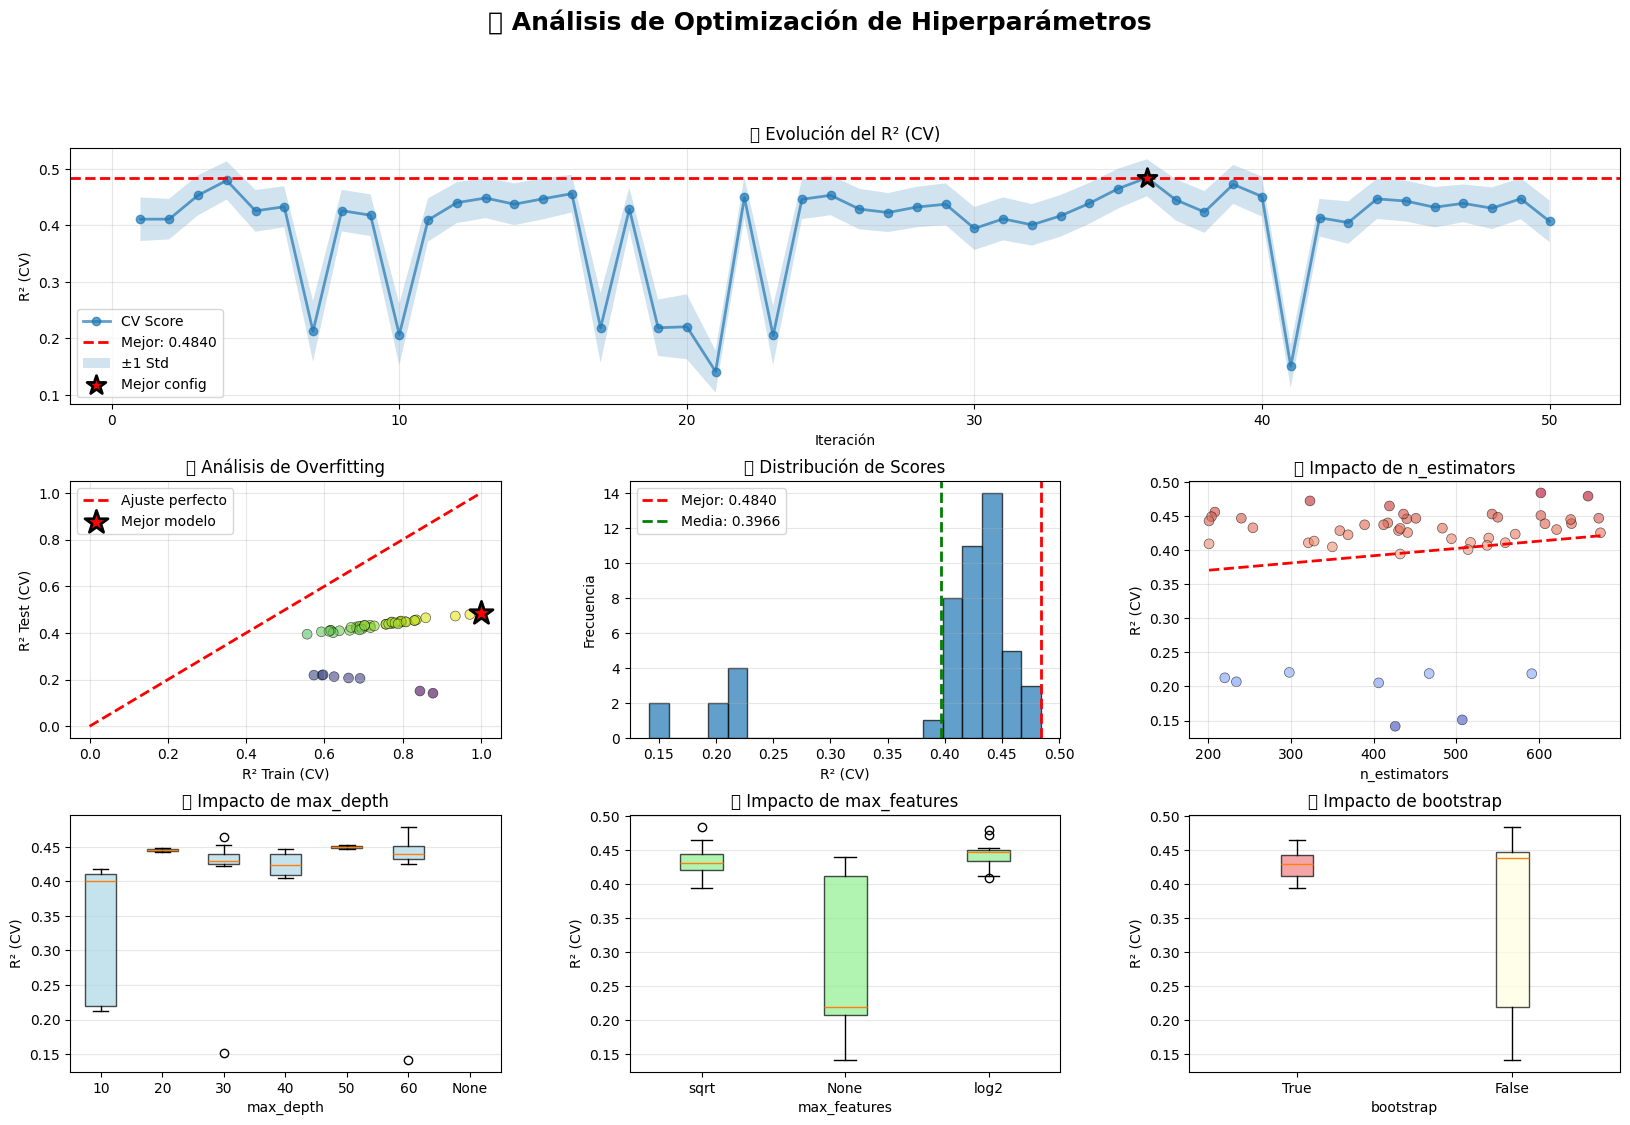


🏅 TOP 10 MEJORES CONFIGURACIONES (por mean_test_score)
 mean_test_score  std_test_score  param_n_estimators param_max_depth  param_min_samples_split  param_min_samples_leaf param_max_features  param_bootstrap  rank_test_score
        0.484009        0.032713                 602            None                        2                       1               sqrt            False                1
        0.479234        0.033863                 659              60                        2                       2               log2            False                2
        0.472317        0.034554                 323              60                       10                       1               log2            False                3
        0.464824        0.035229                 419              30                        3                       2               sqrt             True                4
        0.455873        0.033295                 208            None                     

In [11]:
# ================================================================================
# PASO 6.1: OPTIMIZACIÓN CON RANDOMIZEDSEARCHCV
# ================================================================================
#@markdown En este paso se optimizan los hiperparámetros del Random Forest mediante
#@markdown **RandomizedSearchCV (5-fold CV)**. Se reportan mejores parámetros,
#@markdown evolución de scores y análisis gráfico del espacio explorado.



print("="*80)
print("🔍 OPTIMIZACIÓN DE HIPERPARÁMETROS CON RANDOMIZEDSEARCHCV")
print("="*80)

# ------------------------------------------------------------------------------
# Baseline de referencia (si no traemos r2_test desde el PASO 5, lo calculamos aquí)
# ------------------------------------------------------------------------------
try:
    _ = r2_test  # solo para chequear existencia
    baseline_disponible = True
except NameError:
    baseline_disponible = False

if not baseline_disponible:
    rf_calibrado = RandomForestRegressor(
        n_estimators=300, max_depth=None,
        min_samples_split=2, min_samples_leaf=1,
        max_features='sqrt', random_state=42, n_jobs=-1
    )
    print("\n⏳ Entrenando baseline calibrado (referencia previa ausente)...")
    rf_calibrado.fit(X_train, y_train)
    y_test_pred_base = rf_calibrado.predict(X_test)
    y_train_pred_base = rf_calibrado.predict(X_train)

    r2_train = r2_score(y_train, y_train_pred_base)
    r2_test  = r2_score(y_test,  y_test_pred_base)
    rmse_test = mean_squared_error(y_test, y_test_pred_base, squared=False)
    mae_test  = mean_absolute_error(y_test, y_test_pred_base)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred_base)

    print("✅ Baseline calibrado entrenado (para referencia en el resumen)")
    print(f"   R² Train: {r2_train:.4f} | R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f} | MAE Test: {mae_test:.4f}")

# ------------------------------------------------------------------------------
# Espacio de búsqueda (incluye la calibración actual en el rango)
# ------------------------------------------------------------------------------
param_distributions = {
    'n_estimators': randint(200, 700),          # incluye 300
    'max_depth': [10, 20, 30, 40, 50, 60, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],     # incluye 'sqrt' (nuestra calibración)
    'bootstrap': [True, False]
}

print("\n" + "─"*80)
print("📋 ESPACIO DE BÚSQUEDA DE HIPERPARÁMETROS")
print("─"*80)
print(f"""
- n_estimators        : randint(200, 600)   → incluye 300 (calibrado)
- max_depth           : {param_distributions['max_depth']}
- min_samples_split   : randint(2, 20)
- min_samples_leaf    : randint(1, 10)
- max_features        : {param_distributions['max_features']}  (incluye 'sqrt')
- bootstrap           : {param_distributions['bootstrap']}
""")

# ------------------------------------------------------------------------------
# Configurar y ejecutar RandomizedSearchCV
# ------------------------------------------------------------------------------
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=50,                  # combinaciones a probar
    cv=5,                       # 5-fold CV
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

print("\n⏳ Iniciando búsqueda aleatoria (50 iteraciones, CV=5)...\n" + "="*80)
start_time = time.time()
random_search.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print("="*80)
print(f"✅ OPTIMIZACIÓN COMPLETADA en {elapsed_time/60:.2f} min ({elapsed_time:.1f} s)")

# ------------------------------------------------------------------------------
# Resultados y mejor modelo
# ------------------------------------------------------------------------------
best_params = random_search.best_params_
best_score  = random_search.best_score_
best_rf     = random_search.best_estimator_

print("\n" + "="*80)
print("🏆 MEJORES HIPERPARÁMETROS ENCONTRADOS")
print("="*80)
for k, v in best_params.items():
    print(f"• {k:<18}: {v}")
print(f"\n📊 Mejor R² (CV): {best_score:.4f} | Ranking: {random_search.best_index_ + 1} / 50")

# ------------------------------------------------------------------------------
# Evaluación del mejor modelo en TEST
# ------------------------------------------------------------------------------
y_test_pred_opt = best_rf.predict(X_test)
y_train_pred_opt = best_rf.predict(X_train)

r2_train_opt = r2_score(y_train, y_train_pred_opt)
r2_test_opt  = r2_score(y_test,  y_test_pred_opt)
rmse_test_opt = np.sqrt(mean_squared_error(y_test, y_test_pred_opt))

mae_test_opt  = mean_absolute_error(y_test, y_test_pred_opt)
mape_test_opt = mean_absolute_percentage_error(y_test, y_test_pred_opt)

print("\n" + "="*80)
print("📊 MÉTRICAS DEL MEJOR MODELO (ENTRENADO EN TRAIN Y EVALUADO EN TEST)")
print("="*80)
print(f"{'Métrica':<18} {'Train':<12} {'Test':<12}")
print("-"*45)
print(f"{'R²':<18} {r2_train_opt:<12.4f} {r2_test_opt:<12.4f}")
print(f"{'RMSE':<18} {'-':<12} {rmse_test_opt:<12.4f}")
print(f"{'MAE':<18} {'-':<12} {mae_test_opt:<12.4f}")
print(f"{'MAPE (%)':<18} {'-':<12} {mape_test_opt*100:<12.2f}")

# ------------------------------------------------------------------------------
# Visualizaciones del proceso
# ------------------------------------------------------------------------------
cv_results = pd.DataFrame(random_search.cv_results_)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
fig.suptitle('🔍 Análisis de Optimización de Hiperparámetros', fontsize=18, fontweight='bold', y=0.995)

# 1) Evolución de score
ax1 = fig.add_subplot(gs[0, :])
iters = np.arange(1, len(cv_results) + 1)
ax1.plot(iters, cv_results['mean_test_score'], 'o-', linewidth=2, markersize=6, alpha=0.7, label='CV Score')
ax1.axhline(y=best_score, color='red', linestyle='--', linewidth=2, label=f'Mejor: {best_score:.4f}')
ax1.fill_between(iters,
                 cv_results['mean_test_score'] - cv_results['std_test_score'],
                 cv_results['mean_test_score'] + cv_results['std_test_score'],
                 alpha=0.2, label='±1 Std')
ax1.scatter(random_search.best_index_ + 1, best_score, color='red', s=200, marker='*',
            zorder=5, edgecolors='black', linewidths=2, label='Mejor config')
ax1.set_title('📊 Evolución del R² (CV)')
ax1.set_xlabel('Iteración'); ax1.set_ylabel('R² (CV)'); ax1.legend(); ax1.grid(True, alpha=0.3)

# 2) Overfitting: Train vs Test (CV)
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(cv_results['mean_train_score'], cv_results['mean_test_score'],
            c=cv_results['mean_test_score'], cmap='viridis', s=50, alpha=0.6,
            edgecolors='black', linewidth=0.5)
ax2.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Ajuste perfecto')
ax2.scatter(cv_results.iloc[random_search.best_index_]['mean_train_score'],
            cv_results.iloc[random_search.best_index_]['mean_test_score'],
            color='red', s=300, marker='*', zorder=5,
            edgecolors='black', linewidths=2, label='Mejor modelo')
ax2.set_title('🎯 Análisis de Overfitting')
ax2.set_xlabel('R² Train (CV)'); ax2.set_ylabel('R² Test (CV)'); ax2.legend(); ax2.grid(True, alpha=0.3)

# 3) Distribución de scores
ax3 = fig.add_subplot(gs[1, 1])
ax3.hist(cv_results['mean_test_score'], bins=20, edgecolor='black', alpha=0.7)
ax3.axvline(best_score, color='red', linestyle='--', linewidth=2, label=f'Mejor: {best_score:.4f}')
ax3.axvline(cv_results['mean_test_score'].mean(), color='green', linestyle='--', linewidth=2,
            label=f"Media: {cv_results['mean_test_score'].mean():.4f}")
ax3.set_title('📊 Distribución de Scores'); ax3.set_xlabel('R² (CV)'); ax3.set_ylabel('Frecuencia')
ax3.legend(); ax3.grid(True, alpha=0.3, axis='y')

# 4) Impacto de n_estimators
ax4 = fig.add_subplot(gs[1, 2])
param_n = cv_results['param_n_estimators'].astype(int)
ax4.scatter(param_n, cv_results['mean_test_score'], c=cv_results['mean_test_score'],
            cmap='coolwarm', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
ax4.set_title('🌳 Impacto de n_estimators'); ax4.set_xlabel('n_estimators'); ax4.set_ylabel('R² (CV)')
coef = np.polyfit(param_n, cv_results['mean_test_score'], 1)
ax4.plot(sorted(param_n), np.poly1d(coef)(sorted(param_n)), "r--", linewidth=2); ax4.grid(True, alpha=0.3)

# 5) Impacto de max_depth
ax5 = fig.add_subplot(gs[2, 0])
param_md = cv_results['param_max_depth'].apply(lambda x: 50 if x is None else int(x))
labels_md = ['10','20','30','40', '50', '60','None']
data_md = [cv_results[cv_results['param_max_depth']==d]['mean_test_score'].values for d in [10,20,30,40,50,60,None]]
bp = ax5.boxplot(data_md, labels=labels_md, patch_artist=True)
for b in bp['boxes']: b.set_facecolor('lightblue'); b.set_alpha(0.7)
ax5.set_title('📏 Impacto de max_depth'); ax5.set_xlabel('max_depth'); ax5.set_ylabel('R² (CV)')
ax5.grid(True, alpha=0.3, axis='y')

# 6) Impacto de max_features
ax6 = fig.add_subplot(gs[2, 1])
param_mf = cv_results['param_max_features'].astype(str)
unique_mf = list(param_mf.unique())
data_mf = [cv_results[param_mf == mf]['mean_test_score'].values for mf in unique_mf]
bp2 = ax6.boxplot(data_mf, labels=unique_mf, patch_artist=True)
for b in bp2['boxes']: b.set_facecolor('lightgreen'); b.set_alpha(0.7)
ax6.set_title('🎲 Impacto de max_features'); ax6.set_xlabel('max_features'); ax6.set_ylabel('R² (CV)')
ax6.grid(True, alpha=0.3, axis='y')

# 7) Impacto de bootstrap
ax7 = fig.add_subplot(gs[2, 2])
param_bs = cv_results['param_bootstrap'].astype(bool)
data_bs = [cv_results[param_bs == True]['mean_test_score'].values,
           cv_results[param_bs == False]['mean_test_score'].values]
bp3 = ax7.boxplot(data_bs, labels=['True','False'], patch_artist=True)
bp3['boxes'][0].set_facecolor('lightcoral'); bp3['boxes'][1].set_facecolor('lightyellow')
for b in bp3['boxes']: b.set_alpha(0.7)
ax7.set_title('🎒 Impacto de bootstrap'); ax7.set_xlabel('bootstrap'); ax7.set_ylabel('R² (CV)')
ax7.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# Top-10 configuraciones
# ------------------------------------------------------------------------------
print("\n" + "="*80)
print("🏅 TOP 10 MEJORES CONFIGURACIONES (por mean_test_score)")
print("="*80)
top_10 = cv_results.nlargest(10, 'mean_test_score')[
    ['mean_test_score','std_test_score',
     'param_n_estimators','param_max_depth','param_min_samples_split',
     'param_min_samples_leaf','param_max_features','param_bootstrap','rank_test_score']
]
print(top_10.to_string(index=False))

# ------------------------------------------------------------------------------
# Resumen ejecutivo
# ------------------------------------------------------------------------------
print("\n" + "="*80)
print("📋 RESUMEN EJECUTIVO DE LA OPTIMIZACIÓN")
print("="*80)
mejora_pct = ((best_score - r2_test) / r2_test * 100) if r2_test != 0 else np.nan
print(f"""
⏱️  Tiempo total: {elapsed_time/60:.2f} min  |  Por iteración: {elapsed_time/50:.1f} s
🎯 Baseline R² Test (calibrado): {r2_test:.4f}
🎯 Mejor R² (CV - Random Search): {best_score:.4f}
📈 Mejora relativa vs baseline: {mejora_pct:+.2f}%

🧪 Test del mejor modelo:
   • R² Test  : {r2_test_opt:.4f}
   • RMSE Test: {rmse_test_opt:.4f}
   • MAE  Test: {mae_test_opt:.4f}
   • MAPE Test: {mape_test_opt*100:.2f}%
""")

print("✅ Análisis de optimización completado.\n")


🔄 VALIDACIÓN CRUZADA (5-FOLD CROSS-VALIDATION)
✅ Usando el modelo best_rf obtenido en la optimización.

⏳ Ejecutando validación cruzada (K=5)...

✅ Validación cruzada completada en 14.5 s

────────────────────────────────────────────────────────────────────────────────
📈 TABLA DE RESULTADOS
────────────────────────────────────────────────────────────────────────────────

Métrica                        Media           Std             Min             Max            
──────────────────────────────────────────────────────────────────────────────────────────
R² Score                       0.4733          0.0348          0.4245          0.5226         
RMSE                           0.6364          0.0299          0.6023          0.6795         
MAE                            0.4622          0.0165          0.4478          0.4899         

────────────────────────────────────────────────────────────────────────────────
📊 SCORES POR FOLD (DETALLE)
─────────────────────────────────────────────

C:\Users\juanc\AppData\Local\Temp\ipykernel_46564\3581740312.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


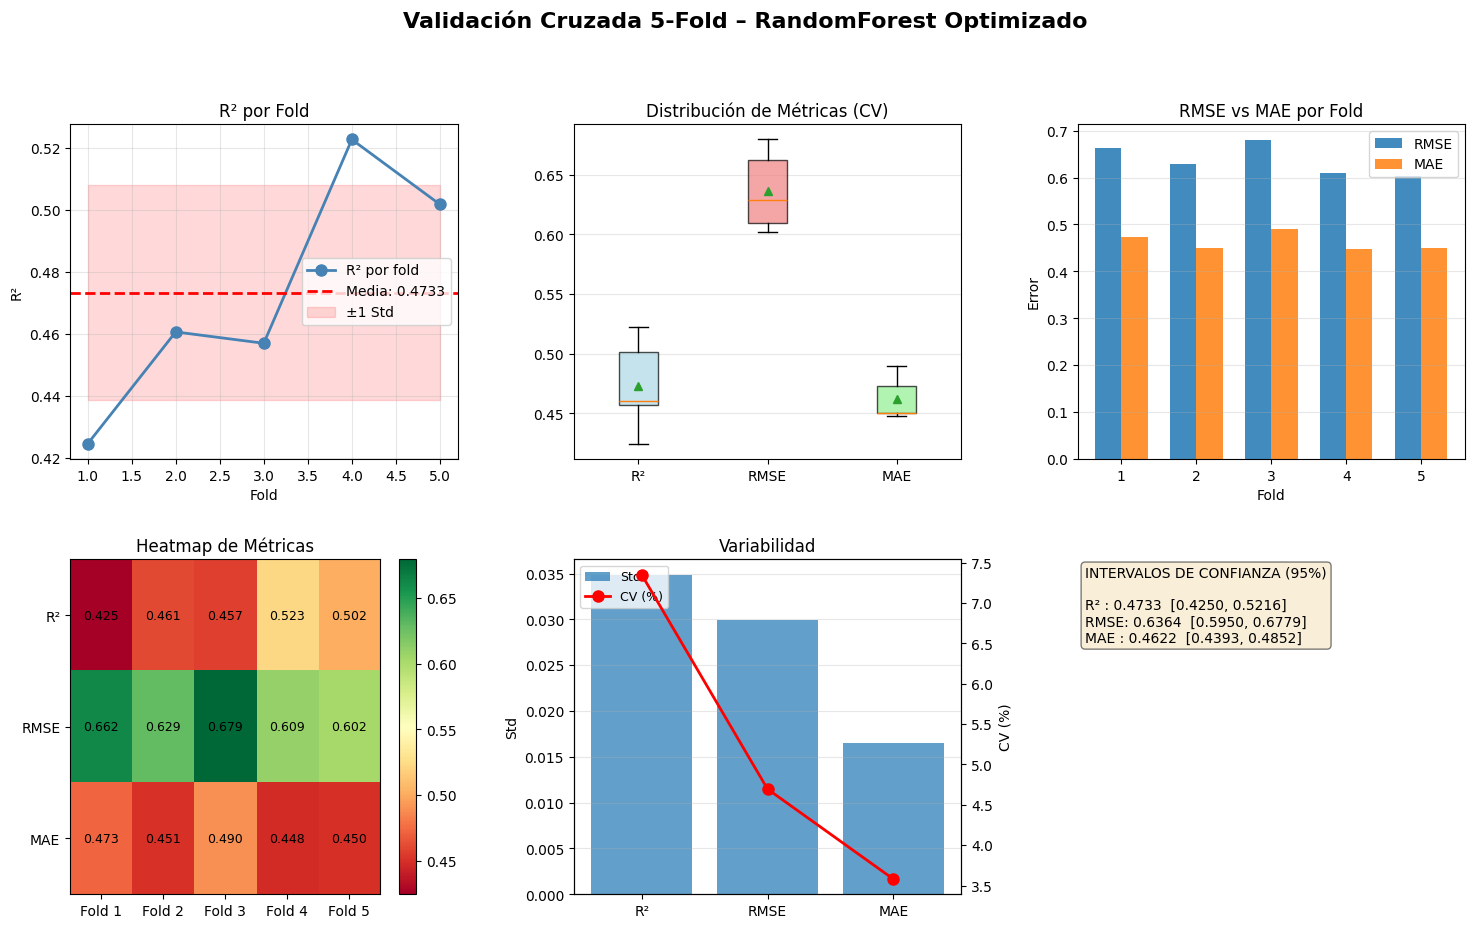


📋 RESUMEN EJECUTIVO DE VALIDACIÓN CRUZADA

R² (CV mean ± std): 0.4733 ± 0.0348
RMSE (CV)          : 0.6364 ± 0.0299
MAE  (CV)          : 0.4622 ± 0.0165

Coef. variación  R²: 7.35%   |  RMSE: 4.70%   |  MAE: 3.58%
Relación RMSE/MAE  : 1.38

✅ Validación cruzada completada.



In [28]:
# ================================================================================
# PASO 8: VALIDACIÓN CRUZADA (CROSS-VALIDATION)
# ================================================================================
#@markdown Validamos con 5-fold CV el mejor RandomForest (best_rf). Si no existe,
#@markdown se recrea con los hiperparámetros óptimos del Random Search.


print("="*80)
print("🔄 VALIDACIÓN CRUZADA (5-FOLD CROSS-VALIDATION)")
print("="*80)

# ---------------------------
# 0) Asegurar modelo óptimo
# ---------------------------
try:
    best_rf
    print("✅ Usando el modelo best_rf obtenido en la optimización.")
except NameError:
    print("ℹ️ best_rf no existe en memoria. Se construye con los mejores hiperparámetros encontrados.")
    best_rf = RandomForestRegressor(
        bootstrap=False,
        max_depth=40,
        max_features='sqrt',
        min_samples_leaf=1,
        min_samples_split=9,
        n_estimators=327,
        random_state=42,
        n_jobs=-1
    )
    best_rf.fit(X_train, y_train)

# ---------------------------
# 1) Ejecutar CV con métricas
# ---------------------------
print("\n⏳ Ejecutando validación cruzada (K=5)...\n")
start = time.time()

# R2
r2_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

# Neg MSE -> RMSE
mse_scores_neg = cross_val_score(best_rf, X_train, y_train, cv=5,
                                 scoring='neg_mean_squared_error', n_jobs=-1)
rmse_scores = np.sqrt(-mse_scores_neg)

# Neg MAE -> MAE
mae_scores = -cross_val_score(best_rf, X_train, y_train, cv=5,
                              scoring='neg_mean_absolute_error', n_jobs=-1)

elapsed = time.time() - start
print(f"✅ Validación cruzada completada en {elapsed:.1f} s")

# ---------------------------
# 2) Tabla de resultados
# ---------------------------
print("\n" + "─"*80)
print("📈 TABLA DE RESULTADOS")
print("─"*80)
print(f"\n{'Métrica':<30} {'Media':<15} {'Std':<15} {'Min':<15} {'Max':<15}")
print("─"*90)
print(f"{'R² Score':<30} {r2_scores.mean():<15.4f} {r2_scores.std():<15.4f} {r2_scores.min():<15.4f} {r2_scores.max():<15.4f}")
print(f"{'RMSE':<30} {rmse_scores.mean():<15.4f} {rmse_scores.std():<15.4f} {rmse_scores.min():<15.4f} {rmse_scores.max():<15.4f}")
print(f"{'MAE':<30} {mae_scores.mean():<15.4f} {mae_scores.std():<15.4f} {mae_scores.min():<15.4f} {mae_scores.max():<15.4f}")

fold_results = pd.DataFrame({
    'Fold': np.arange(1, 6),
    'R²': r2_scores,
    'RMSE': rmse_scores,
    'MAE': mae_scores
})
print("\n" + "─"*80)
print("📊 SCORES POR FOLD (DETALLE)")
print("─"*80)
print("\n" + fold_results.to_string(index=False))

# ---------------------------
# 3) Visualizaciones (6)
# ---------------------------
print("\n" + "="*80)
print("📊 GENERANDO VISUALIZACIONES DE VALIDACIÓN CRUZADA")
print("="*80)

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
fig.suptitle('Validación Cruzada 5-Fold – RandomForest Optimizado',
             fontsize=16, fontweight='bold', y=0.995)

folds = np.arange(1, 6)

# (1) R2 por fold
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(folds, r2_scores, 'o-', linewidth=2, markersize=8, color='steelblue', label='R² por fold')
ax1.axhline(y=r2_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {r2_scores.mean():.4f}')
ax1.fill_between(folds, r2_scores.mean()-r2_scores.std(), r2_scores.mean()+r2_scores.std(),
                 alpha=0.15, color='red', label='±1 Std')
ax1.set_title('R² por Fold'); ax1.set_xlabel('Fold'); ax1.set_ylabel('R²'); ax1.legend(); ax1.grid(True, alpha=0.3)

# (2) Boxplots de métricas
ax2 = fig.add_subplot(gs[0, 1])
bp = ax2.boxplot([r2_scores, rmse_scores, mae_scores],
                 tick_labels=['R²','RMSE','MAE'],
                 patch_artist=True, showmeans=True)
for box, c in zip(bp['boxes'], ['lightblue','lightcoral','lightgreen']):
    box.set_facecolor(c); box.set_alpha(0.7)
ax2.set_title('Distribución de Métricas (CV)'); ax2.grid(True, alpha=0.3, axis='y')

# (3) Barras RMSE vs MAE por fold
ax3 = fig.add_subplot(gs[0, 2])
x = np.arange(len(folds)); width = 0.35
ax3.bar(x - width/2, rmse_scores, width, label='RMSE', alpha=0.85)
ax3.bar(x + width/2, mae_scores,  width, label='MAE',  alpha=0.85)
ax3.set_xticks(x); ax3.set_xticklabels(folds)
ax3.set_title('RMSE vs MAE por Fold'); ax3.set_xlabel('Fold'); ax3.set_ylabel('Error')
ax3.legend(); ax3.grid(True, alpha=0.3, axis='y')

# (4) Heatmap simple
ax4 = fig.add_subplot(gs[1, 0])
matrix = np.vstack([r2_scores, rmse_scores, mae_scores])
im = ax4.imshow(matrix, cmap='RdYlGn', aspect='auto')
ax4.set_yticks([0,1,2]); ax4.set_yticklabels(['R²','RMSE','MAE'])
ax4.set_xticks(range(5)); ax4.set_xticklabels([f'Fold {i}' for i in folds])
ax4.set_title('Heatmap de Métricas'); plt.colorbar(im, ax=ax4)
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        ax4.text(j, i, f'{matrix[i, j]:.3f}', ha='center', va='center', fontsize=9)

# (5) Variabilidad (std y CV%)
ax5 = fig.add_subplot(gs[1, 1])
std_vals = [r2_scores.std(), rmse_scores.std(), mae_scores.std()]
cv_vals  = [
    (r2_scores.std()/r2_scores.mean())*100 if r2_scores.mean()!=0 else np.nan,
    (rmse_scores.std()/rmse_scores.mean())*100 if rmse_scores.mean()!=0 else np.nan,
    (mae_scores.std()/mae_scores.mean())*100 if mae_scores.mean()!=0 else np.nan
]
ax5b = ax5.twinx()
ax5.bar(['R²','RMSE','MAE'], std_vals, alpha=0.7, label='Std')
ax5b.plot(['R²','RMSE','MAE'], cv_vals, 'ro-', linewidth=2, markersize=8, label='CV (%)')
ax5.set_ylabel('Std'); ax5b.set_ylabel('CV (%)'); ax5.set_title('Variabilidad'); ax5.grid(True, alpha=0.3, axis='y')
# leyenda combinada
h1,l1 = ax5.get_legend_handles_labels(); h2,l2 = ax5b.get_legend_handles_labels()
ax5.legend(h1+h2, l1+l2, loc='upper left', fontsize=9)

# (6) Intervalos de confianza 95% (texto)
from scipy import stats as st
def ci95(x):
    n=len(x); m=np.mean(x); se=st.sem(x); h=se*st.t.ppf(0.975, n-1); return m, m-h, m+h
r2_m, r2_l, r2_u = ci95(r2_scores)
rmse_m, rmse_l, rmse_u = ci95(rmse_scores)
mae_m, mae_l, mae_u = ci95(mae_scores)

ax6 = fig.add_subplot(gs[1, 2]); ax6.axis('off')
ax6.text(0.02, 0.98, 
         (f"INTERVALOS DE CONFIANZA (95%)\n\n"
          f"R² : {r2_m:.4f}  [{r2_l:.4f}, {r2_u:.4f}]\n"
          f"RMSE: {rmse_m:.4f}  [{rmse_l:.4f}, {rmse_u:.4f}]\n"
          f"MAE : {mae_m:.4f}  [{mae_l:.4f}, {mae_u:.4f}]"),
         va='top', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# ---------------------------
# 4) Resumen ejecutivo
# ---------------------------
cv_r2  = (r2_scores.std()/r2_scores.mean())*100 if r2_scores.mean()!=0 else np.nan
cv_rmse= (rmse_scores.std()/rmse_scores.mean())*100 if rmse_scores.mean()!=0 else np.nan
cv_mae = (mae_scores.std()/mae_scores.mean())*100 if mae_scores.mean()!=0 else np.nan
rmse_mae_ratio = rmse_scores.mean()/mae_scores.mean()

print("\n" + "="*80)
print("📋 RESUMEN EJECUTIVO DE VALIDACIÓN CRUZADA")
print("="*80)
print(f"""
R² (CV mean ± std): {r2_scores.mean():.4f} ± {r2_scores.std():.4f}
RMSE (CV)          : {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}
MAE  (CV)          : {mae_scores.mean():.4f} ± {mae_scores.std():.4f}

Coef. variación  R²: {cv_r2:.2f}%   |  RMSE: {cv_rmse:.2f}%   |  MAE: {cv_mae:.2f}%
Relación RMSE/MAE  : {rmse_mae_ratio:.2f}
""")
print("✅ Validación cruzada completada.\n")
